# TP1 - Regresión
Notebook inicial para el trabajo práctico.

In [104]:
# 1. Importación de librerías necesarias
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import holidays

In [105]:
file_path= 'uber_fares.csv'
df = pd.read_csv(file_path)
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [106]:
# Se realiza un análisis inicial para comprender el comportamiento de cada variable.
df.info(), df.apply(pd.unique), df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


(None,
 key                  [24238194, 27835199, 44984355, 25894730, 17610...
 date                 [2015-05-07 19:52:06.0000003, 2009-07-17 20:04...
 fare_amount          [7.5, 7.7, 12.9, 5.3, 16.0, 4.9, 24.5, 2.5, 9....
 pickup_datetime      [2015-05-07 19:52:06 UTC, 2009-07-17 20:04:56 ...
 pickup_longitude     [-73.99981689453125, -73.994355, -74.005043, -...
 pickup_latitude      [40.73835372924805, 40.728225, 40.74077, 40.79...
 dropoff_longitude    [-73.99951171875, -73.99471, -73.962565, -73.9...
 dropoff_latitude     [40.72321701049805, 40.750325, 40.772647, 40.8...
 passenger_count                             [1, 3, 5, 2, 4, 6, 0, 208]
 dtype: object,
 key                  200000
 date                 200000
 fare_amount            1244
 pickup_datetime      196629
 pickup_longitude      71066
 pickup_latitude       83835
 dropoff_longitude     76894
 dropoff_latitude      90585
 passenger_count           8
 dtype: int64)

In [107]:
# Eliminar la columna 'key' porque no aporta al análisis
df = df.drop(columns=['key'])

In [108]:
# Análisis de redundancia entre 'date' y 'pickup_datetime'
print("Comparación entre las columnas 'date' y 'pickup_datetime':")
print("\nPrimeras 5 filas de ambas columnas:")
if 'date' in df.columns:
    print(df[['date', 'pickup_datetime']].head())
    
    
    df['fecha_extraida'] = pd.to_datetime(df['pickup_datetime']).dt.date
    df['date_convertida'] = pd.to_datetime(df['date']).dt.date if 'date' in df.columns else None
    
    print(f"\n¿Las fechas coinciden? {(df['fecha_extraida'] == df['date_convertida']).all()}")
    print(f"Número de coincidencias: {(df['fecha_extraida'] == df['date_convertida']).sum()}")
    print(f"Total de registros: {len(df)}")
    
    
    df = df.drop(columns=['fecha_extraida', 'date_convertida'])
else:
    print("La columna 'date' ya fue eliminada.")
    print("pickup_datetime contiene tanto la fecha como la hora:")
    print(df[['pickup_datetime']].head())
    print(f"\nTipo de datos: {df['pickup_datetime'].dtype}")
    print(f"Ejemplo de información temporal extraíble:")
    print(f"- Fecha: {pd.to_datetime(df['pickup_datetime']).dt.date.iloc[0]}")
    print(f"- Hora: {pd.to_datetime(df['pickup_datetime']).dt.time.iloc[0]}")
    print(f"- Año: {pd.to_datetime(df['pickup_datetime']).dt.year.iloc[0]}")
    print(f"- Mes: {pd.to_datetime(df['pickup_datetime']).dt.month.iloc[0]}")
    print(f"- Día: {pd.to_datetime(df['pickup_datetime']).dt.day.iloc[0]}")

Comparación entre las columnas 'date' y 'pickup_datetime':

Primeras 5 filas de ambas columnas:
                            date          pickup_datetime
0    2015-05-07 19:52:06.0000003  2015-05-07 19:52:06 UTC
1    2009-07-17 20:04:56.0000002  2009-07-17 20:04:56 UTC
2   2009-08-24 21:45:00.00000061  2009-08-24 21:45:00 UTC
3    2009-06-26 08:22:21.0000001  2009-06-26 08:22:21 UTC
4  2014-08-28 17:47:00.000000188  2014-08-28 17:47:00 UTC

¿Las fechas coinciden? True
Número de coincidencias: 200000
Total de registros: 200000


In [109]:
# Eliminamos la columna 'date' porque es completamente redundante con 'pickup_datetime'
# Ambas columnas contienen exactamente la misma información temporal
# pickup_datetime ya nos proporciona fecha y hora completa
df = df.drop(columns=['date'])

In [110]:
# Creamos nueva variable en base a la distancia entre coordenadas de inicio y fin del viaje utilizamos distancia haversine en km
def haversine(lat1, lon1, lat2, lon2):
    
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

df['dist_haversine'] = haversine(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude'])

In [111]:
# Creamos variable dummie para dias no laborables (feriados, sabados y domingos
feriados = holidays.US(state='NY')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['es_feriado'] = df['pickup_datetime'].dt.date.apply(lambda x: 1 if x in feriados else 0)
df['es_fin_de_semana'] = df['pickup_datetime'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
df['es_no_laborable'] = ((df['es_fin_de_semana'] == 1) | (df['es_feriado'] == 1)).astype(int)
df = df.drop(columns=['es_feriado', 'es_fin_de_semana'])

In [112]:
# Creamos la variable hora del dia para luego transformarla en variables circulares
df['hora_del_dia'] = df['pickup_datetime'].dt.hour
df['hora_sin'] = np.sin(2 * np.pi * df['hora_del_dia'] / 24)
df['hora_cos'] = np.cos(2 * np.pi * df['hora_del_dia'] / 24)

In [113]:
# Creamos variable dummie para la quincena del mes
df['1era_mitad_mes'] = (df['pickup_datetime'].dt.day < 15).astype(int)

In [114]:
# Creamos variables dummie para las estaciones del ano
df['pickup_datetime'] = df['pickup_datetime'].dt.tz_localize(None)

def estacion_astronomica(fecha):
    y = fecha.year
    if fecha >= pd.Timestamp(y, 12, 21) or fecha < pd.Timestamp(y, 3, 20):
        return 'invierno'
    elif fecha >= pd.Timestamp(y, 3, 20) and fecha < pd.Timestamp(y, 6, 21):
        return 'primavera'
    elif fecha >= pd.Timestamp(y, 6, 21) and fecha < pd.Timestamp(y, 9, 22):
        return 'verano'
    else:
        return 'otoño'

df['estacion'] = df['pickup_datetime'].apply(estacion_astronomica)

dummies = pd.get_dummies(df['estacion'], prefix='', prefix_sep='')
for estacion in ['invierno', 'primavera', 'verano']:
    df[estacion] = dummies.get(estacion, pd.Series(0, index=df.index)).astype(int)

df = df.drop(columns=['estacion'])

In [115]:
# Análisis de la variable passenger_count para entender su distribución y crear dummies
df['passenger_count'].value_counts()

passenger_count
1      138425
2       29428
5       14009
3        8881
4        4276
6        4271
0         709
208         1
Name: count, dtype: int64

In [116]:
# Crear variables dummies para passenger_count
df['delivery'] = (df['passenger_count'] == 0).astype(int)
df['standard'] = df['passenger_count'].between(1, 4).astype(int)

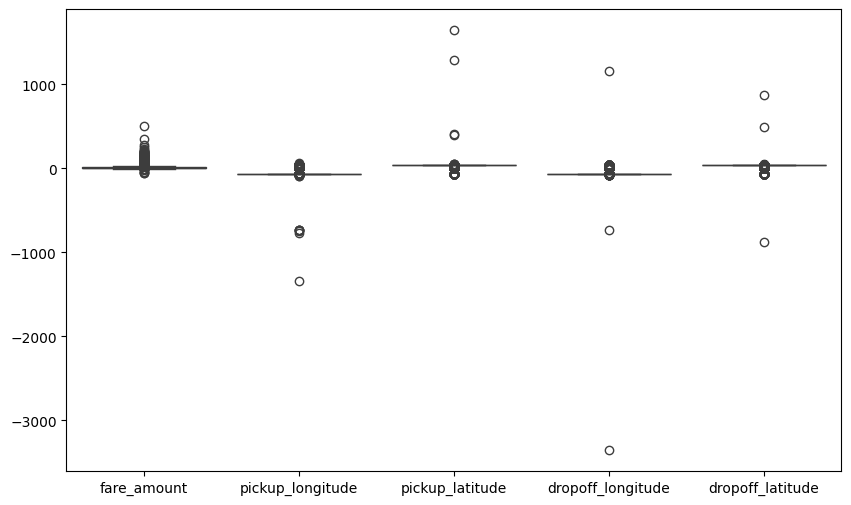

In [117]:
# Notamos que en fare_amount y en las coordenadas hay valores erroneos
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df[['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']])
plt.show()

In [118]:
# Previo a la imputacion realizamos la división en train y test (80% - 20%)
y = df["fare_amount"]
X = df.drop(columns=["fare_amount"])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [119]:
# Visualizamos y borramos valores fuera de rango en longitudes y latitudes. Tomamos esta decision por considerarlos errores y por que son una cantidad
# infima con respecto al total de registros
longitudes_fuera_rango = df_train[
    (df_train['pickup_longitude'] < -180) | (df_train['pickup_longitude'] > 180) |
    (df_train['dropoff_longitude'] < -180) | (df_train['dropoff_longitude'] > 180)
]


latitudes_fuera_rango = df_train[
    (df_train['pickup_latitude'] < -90) | (df_train['pickup_latitude'] > 90) |
    (df_train['dropoff_latitude'] < -90) | (df_train['dropoff_latitude'] > 90)
]

print("Longitudes fuera de rango:")
print(longitudes_fuera_rango[['pickup_longitude', 'dropoff_longitude']])

print("\nLatitudes fuera de rango:")
print(latitudes_fuera_rango[['pickup_latitude', 'dropoff_latitude']])


df_train = df_train[
    (df_train['pickup_longitude'] >= -180) & (df_train['pickup_longitude'] <= 180) &
    (df_train['dropoff_longitude'] >= -180) & (df_train['dropoff_longitude'] <= 180) &
    (df_train['pickup_latitude'] >= -90) & (df_train['pickup_latitude'] <= 90) &
    (df_train['dropoff_latitude'] >= -90) & (df_train['dropoff_latitude'] <= 90)
]

Longitudes fuera de rango:
        pickup_longitude  dropoff_longitude
103745       -736.216667         -73.982377
91422          57.418457        1153.572603
199936       -736.400000         -73.982215
4949         -748.016667         -74.003570
161652       -735.433332         -74.006373
75851       -1340.648410       -3356.666300
48506        -735.200000         -73.980187

Latitudes fuera de rango:
       pickup_latitude  dropoff_latitude
61793       401.066667         40.754117
91422      1292.016128       -881.985513
56617       404.433332         40.769037
75851      1644.421482        872.697628


In [120]:
# Eliminamos filas donde passenger_count sea mayor a 6, ya que no son representativas y pueden distorsionar el análisis
df_train = df_train[df_train['passenger_count'] <= 6]

In [121]:
# Detectamos valores negativos y algunos muy bajos en fare_ammount. Al ver que son pocos y considerarlos errores procedemos a su eliminación.
df_train['fare_amount'].value_counts().sort_index().head(20)


fare_amount
-52.00       2
-50.50       1
-49.57       1
-23.70       1
-10.90       1
-7.30        1
-5.00        1
-3.50        3
-3.30        1
-3.00        2
 0.00        5
 0.01        2
 2.50      662
 2.60        1
 2.90      391
 3.00      287
 3.25        1
 3.30     1102
 3.40        9
 3.50      874
Name: count, dtype: int64

In [122]:
df_train = df_train[df_train['fare_amount'] > 0.11]

In [123]:
# Registros con logitudes y latitudes iguales, es probable que este tipo de registros sean de viajes que empiezan y terminan en el mismo lugar.
# Tambien consideramos que la cantidad de registros es importante por eso creemos necesaria su imputacion.
mask = (df_train['pickup_longitude'] == df_train['dropoff_longitude']) & (df_train['pickup_latitude'] == df_train['dropoff_latitude'])
registros_iguales = df_train[mask]
print(f"Cantidad de registros con misma lat/lon de origen y destino: {registros_iguales.shape[0]}")
registros_iguales

Cantidad de registros con misma lat/lon de origen y destino: 4498


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_haversine,es_no_laborable,hora_del_dia,hora_sin,hora_cos,1era_mitad_mes,invierno,primavera,verano,delivery,standard
67739,20.5,2013-04-10 23:45:47,0.000000,0.000000,0.000000,0.000000,1,0.0,0,23,-0.258819,9.659258e-01,1,0,1,0,0,1
19807,8.6,2009-01-17 01:08:45,-73.979460,40.737350,-73.979460,40.737350,1,0.0,1,1,0.258819,9.659258e-01,0,1,0,0,0,1
18539,5.7,2011-02-12 17:55:00,-74.004560,40.713238,-74.004560,40.713238,1,0.0,1,17,-0.965926,-2.588190e-01,1,1,0,0,0,1
158645,3.0,2009-03-11 05:45:07,-73.789868,40.646754,-73.789868,40.646754,1,0.0,0,5,0.965926,2.588190e-01,1,1,0,0,0,1
150766,3.7,2011-06-20 14:43:00,0.000000,0.000000,0.000000,0.000000,1,0.0,0,14,-0.500000,-8.660254e-01,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68840,4.9,2009-11-09 19:12:12,-73.982444,40.769063,-73.982444,40.769063,1,0.0,0,19,-0.965926,2.588190e-01,1,0,0,0,0,1
61087,9.5,2014-12-11 09:26:29,0.000000,0.000000,0.000000,0.000000,1,0.0,0,9,0.707107,-7.071068e-01,1,0,0,0,0,1
174013,18.0,2013-03-15 11:27:45,0.000000,0.000000,0.000000,0.000000,1,0.0,0,11,0.258819,-9.659258e-01,0,1,0,0,0,1
104488,4.5,2013-07-04 22:49:18,0.000000,0.000000,0.000000,0.000000,1,0.0,1,22,-0.500000,8.660254e-01,1,0,0,1,0,1


In [124]:
# Consideramos que todo viaje menor a 100 metros deber ser un error de carga o probablemente sea mas largo de la distancia entre partida y llegada.

df_train.loc[df_train['dist_haversine'] < 0.1, 'dist_haversine'] = np.nan
dftrain_valid = df_train[~df_train['dist_haversine'].isna()]

# Entrenamos un modelo de regresión lineal para imputar las distancias en relacion al fare_amount

X = dftrain_valid[['fare_amount']]  # fare_amount como predictor
y = dftrain_valid['dist_haversine'] # dist_haversine como target

model = LinearRegression()
model.fit(X, y)


mask_missing = df_train['dist_haversine'].isna()
df_train.loc[mask_missing, 'dist_haversine'] = model.predict(df_train.loc[mask_missing, ['fare_amount']])
df_train.loc[mask_missing, 'dist_haversine'] = df_train.loc[mask_missing, 'dist_haversine'].clip(lower=0)


In [125]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159968 entries, 153248 to 121958
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   fare_amount        159968 non-null  float64       
 1   pickup_datetime    159968 non-null  datetime64[ns]
 2   pickup_longitude   159968 non-null  float64       
 3   pickup_latitude    159968 non-null  float64       
 4   dropoff_longitude  159968 non-null  float64       
 5   dropoff_latitude   159968 non-null  float64       
 6   passenger_count    159968 non-null  int64         
 7   dist_haversine     159968 non-null  float64       
 8   es_no_laborable    159968 non-null  int64         
 9   hora_del_dia       159968 non-null  int32         
 10  hora_sin           159968 non-null  float64       
 11  hora_cos           159968 non-null  float64       
 12  1era_mitad_mes     159968 non-null  int64         
 13  invierno           159968 non-null  int64   

In [126]:
# Eliminamos columnas que no aportan al análisis
df_train = df_train.drop(columns=['pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude',
    'passenger_count', 'hora_del_dia', 'pickup_datetime'
])


df_test = df_test.drop(columns=['pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude',
    'passenger_count', 'hora_del_dia', 'pickup_datetime'
])

In [127]:
# Separar variables predictoras y target en train y test
X_train = df_train.drop(columns=['fare_amount'])
y_train = df_train['fare_amount']

X_test = df_test.drop(columns=['fare_amount'])
y_test = df_test['fare_amount']

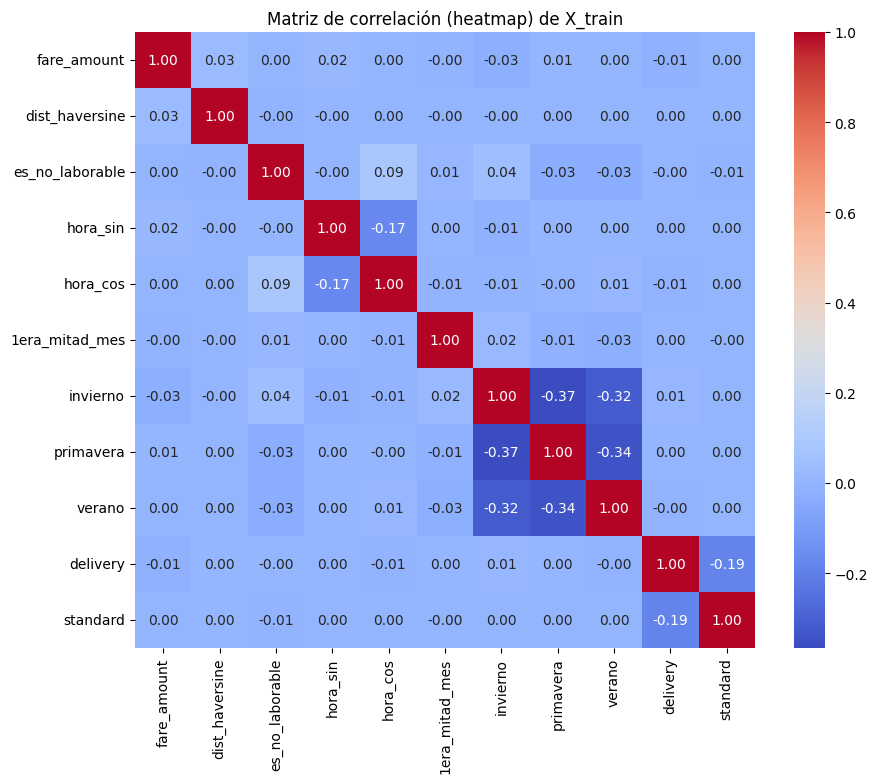

In [128]:
# Heatmap de la matriz de correlación de X_train
corr_matrix = df_train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación (heatmap) de X_train')
plt.show()

In [129]:
# Escalamos variables y realizamos la regresion lineal
scaler = StandardScaler()
X_train['dist_haversine'] = scaler.fit_transform(X_train[['dist_haversine']])
X_test['dist_haversine'] = scaler.transform(X_test[['dist_haversine']])


scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


modelo = LinearRegression()
modelo.fit(X_train, y_train_scaled)
y_pred = modelo.predict(X_test)





y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

# Métricas en escala original
rmse_dolares = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE en dólares: ${rmse_dolares:.2f}")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

RMSE en dólares: $10.30
MSE: 106.14536999579998
R2: 0.0016520342455718096


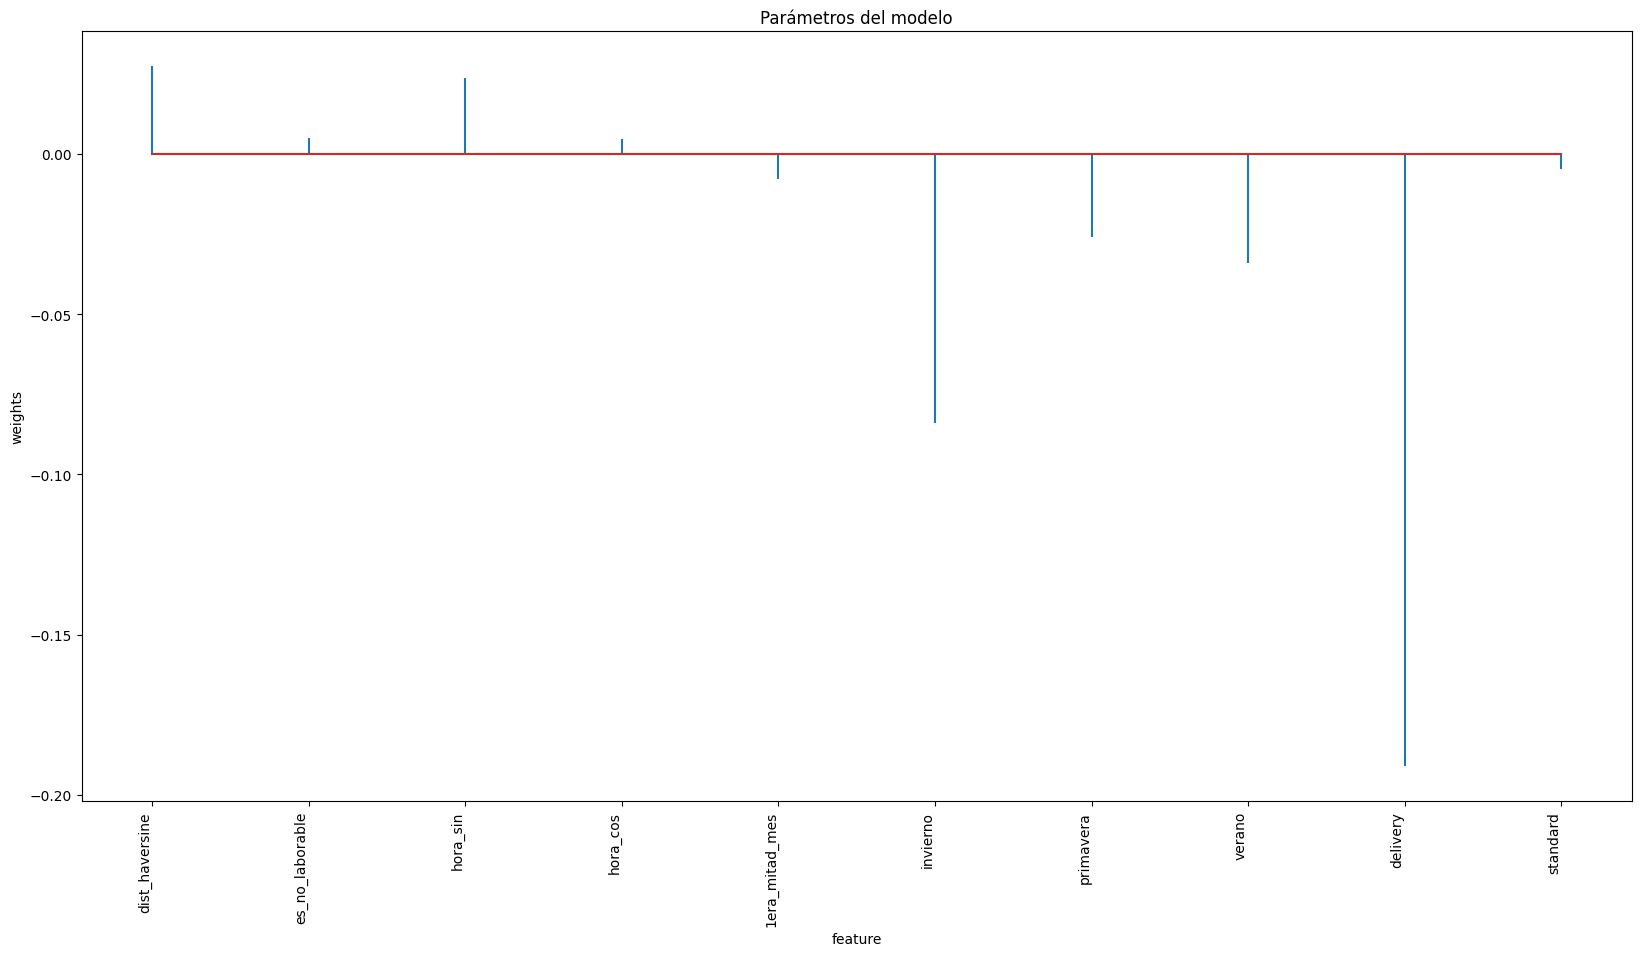

In [130]:
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo');

In [131]:
# Predicciones test

predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([ 0.0327125 , -0.00336202, -0.01090334,  0.0166312 ,  0.02604667,
        0.01886841, -0.05523942, -0.03366324,  0.00529632,  0.00792964])

In [132]:
# Error de test del modelo. Uso rmse para mantener la misma escala que la variable a predecir
predicciones_descaled = scaler_y.inverse_transform(predicciones.reshape(-1, 1))
rmse_ols = np.sqrt(mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones_descaled,
           ))
R2 = r2_score(y_test, predicciones_descaled)
print(f"El error (rmse) de test es: {rmse_ols}")

El error (rmse) de test es: 10.302687513255945


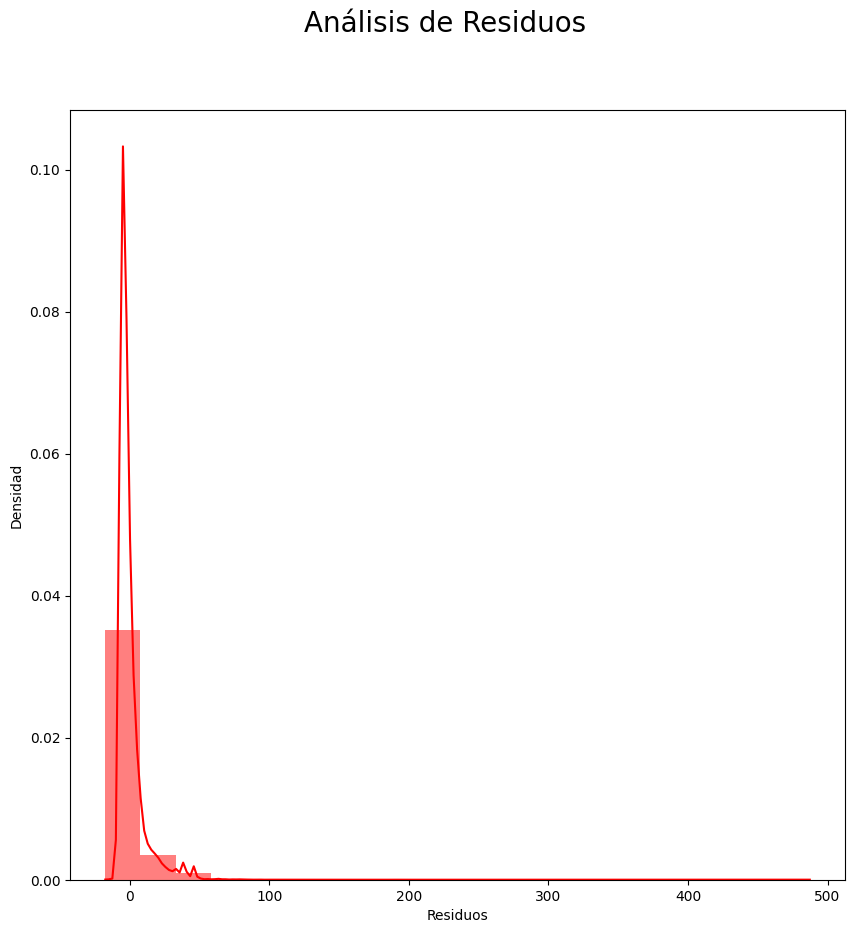

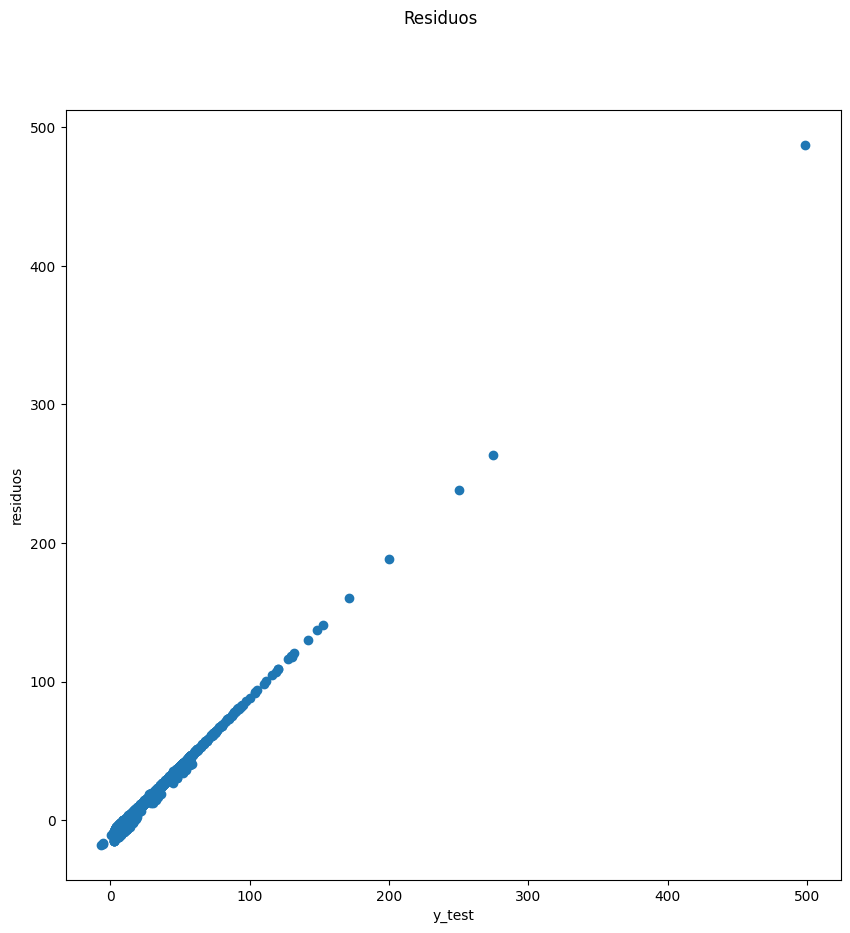

In [133]:
fig = plt.figure(figsize=(10,10))
residuos = y_test - y_pred.reshape(y_test.shape)
sns.histplot(residuos, color="red", kde=True, stat="density", linewidth=0, bins=20)
fig.suptitle('Análisis de Residuos', fontsize=20)
plt.xlabel('Residuos')
plt.ylabel('Densidad')
plt.show()

fig = plt.figure(figsize=(10,10))
fig.suptitle('Residuos')
plt.xlabel('y_test')
plt.ylabel('residuos')
plt.scatter(y_test, y_test - y_pred.flatten())
plt.show()

In [134]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_val.shape[0]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    

    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  
    test_errors = []
    for _ in range(epochs):
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  
        gradient = np.transpose(grad_mul).reshape(-1, 1) 

        W = W - (lr * gradient)

   
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    plt.show()

    return W

In [135]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

In [136]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

In [137]:
# Creamos conjunto de validacion a partir del conjunto de entrenamiento para usar en el gradiente descendente
x_train_gd, x_val_gd, y_train_gd, y_val_gd = train_test_split(
    X_train.values, y_train_scaled, test_size=0.2, random_state=42
)

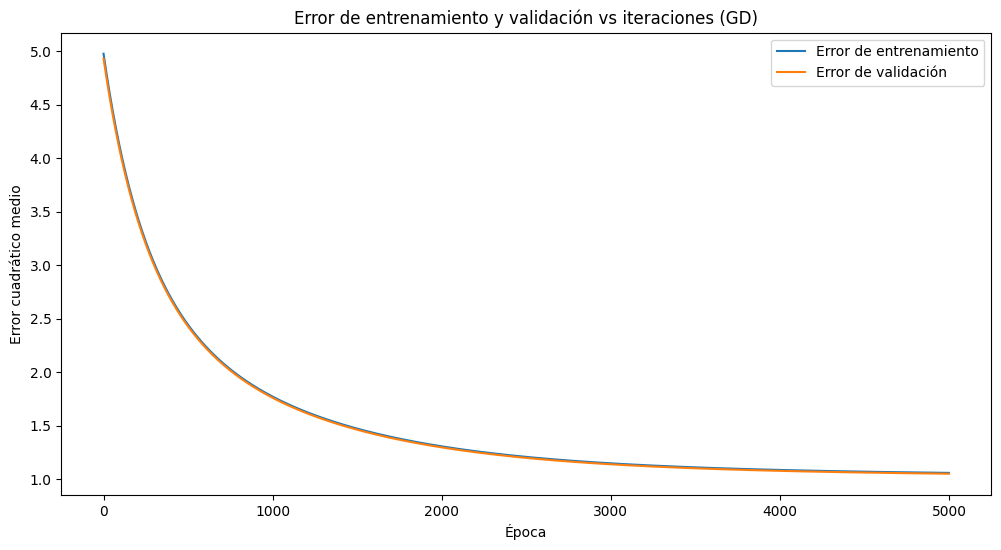

In [138]:
coef_gradiente = gradient_descent(x_train_gd, y_train_gd, x_val_gd, y_val_gd, lr=0.001, epochs=5000)

In [139]:
X_test_gd = np.hstack((np.ones((X_test.shape[0], 1)), X_test.values))

y_pred_gd = np.matmul(X_test_gd, coef_gradiente)

mse = mean_squared_error(y_test_scaled, y_pred_gd)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_scaled, y_pred_gd)
mape = np.mean(np.abs((y_test_scaled - y_pred_gd) / y_test_scaled)) * 100
r2 = r2_score(y_test_scaled, y_pred_gd)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")


MSE: 1.1687638571267345
RMSE: 1.081093824386549
MAE: 0.6547822534266288
MAPE: 166.41110532528194
R2: -0.05380531402165056


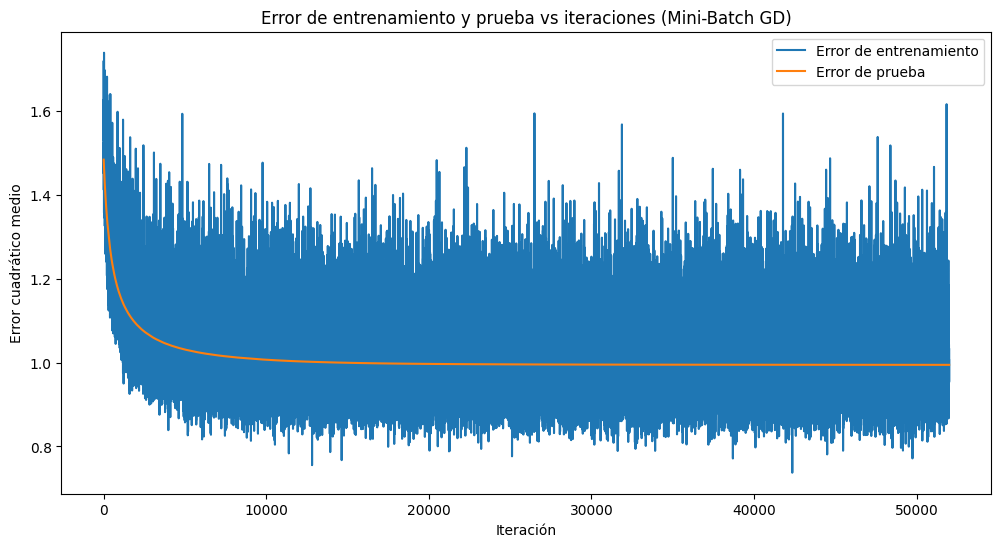

array([[ 0.01301589],
       [ 0.02750979],
       [ 0.00565389],
       [ 0.02272974],
       [ 0.00573611],
       [-0.00708854],
       [-0.07871353],
       [-0.0217713 ],
       [-0.02882188],
       [ 0.35313886],
       [ 0.02747356]])

In [140]:
mini_batch_gradient_descent(x_train_gd, y_train_gd, x_val_gd, y_val_gd, lr=0.001, epochs=2000, batch_size=5000)

In [141]:
mini_batch_gradient_descent(x_train_gd, y_train_gd, x_val_gd, y_val_gd, lr=0.001, epochs=5, batch_size=1)

KeyboardInterrupt: 

In [142]:
# Creación y entrenamiento del modelo. Scikit-Learn usa Cross Validation para encontrar el valor óptimo de alpha
# (lambda en los desarrollos de teoría). Puede ser problemático con series de tiempo.

modelo = RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
         )

_ = modelo.fit(X = X_train, y = y_train_scaled)

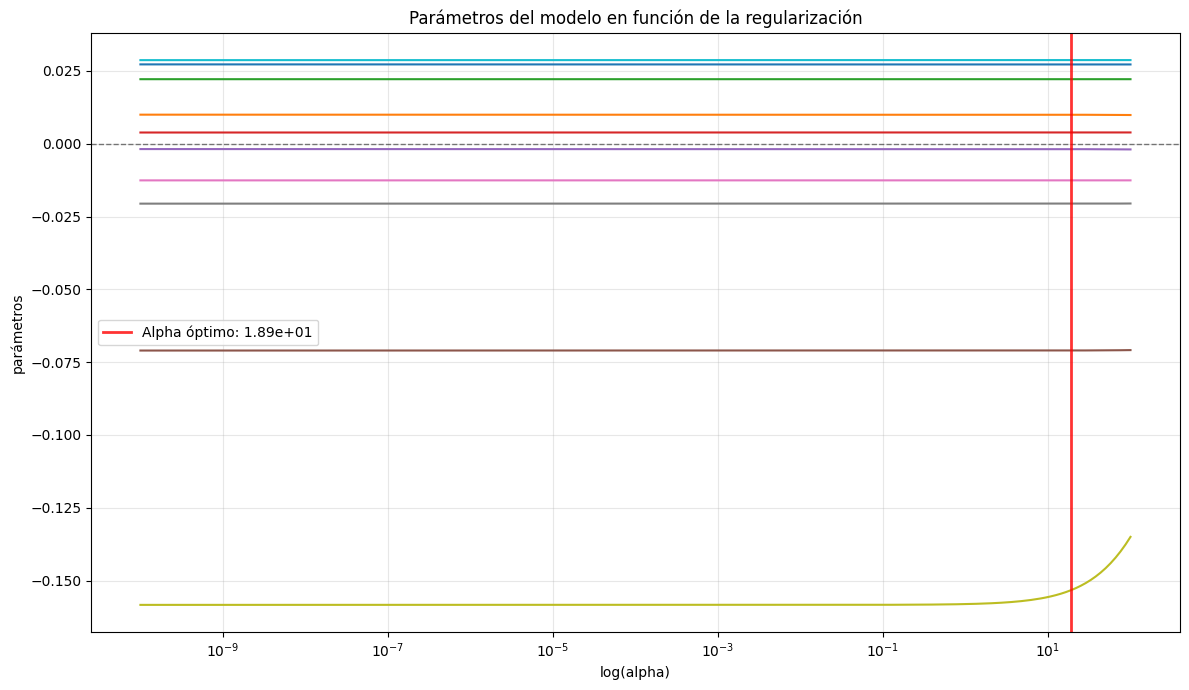

Mejor valor de alpha encontrado: 18.896523396912038


In [146]:

alphas = modelo.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train_scaled)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo en función de la regularización');
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(x=modelo.alpha_, color='red', linestyle='-', alpha=0.8, linewidth=2, 
           label=f'Alpha óptimo: {modelo.alpha_:.2e}')

ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

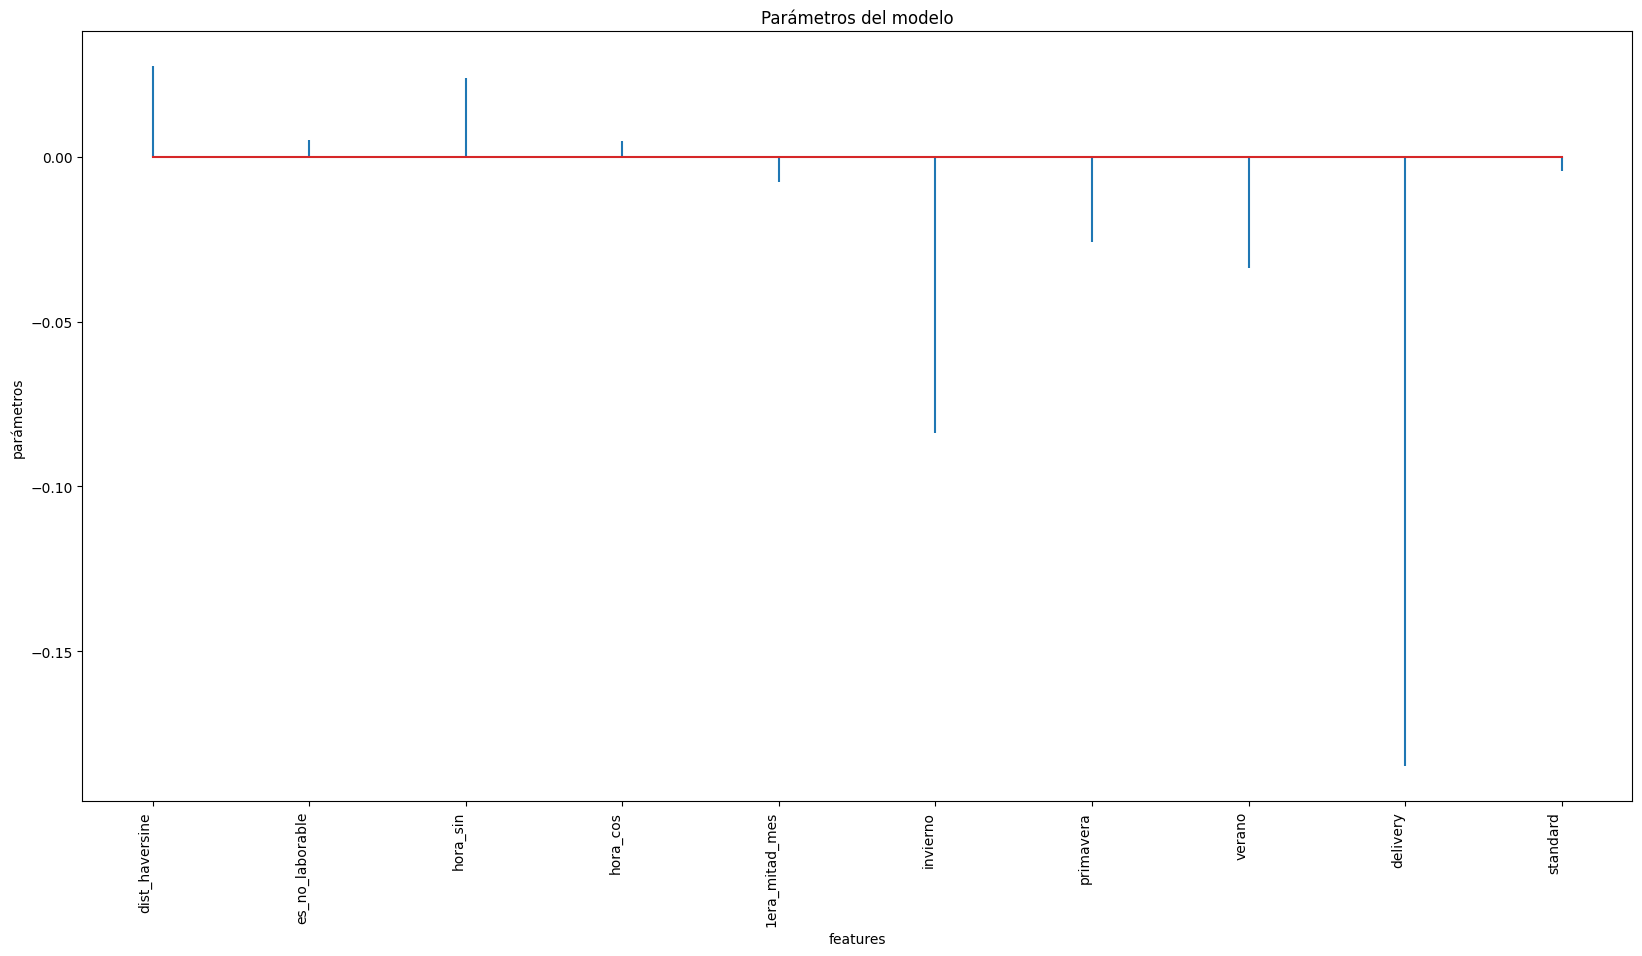

In [ ]:
# Parámetros del modelo

df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('features')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [ ]:
# Predicciones test
predicciones = modelo.predict(X = X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([ 0.03264905, -0.00357918, -0.01112308,  0.01657116,  0.02605922,
        0.01856208, -0.05520268, -0.03362833,  0.00531924,  0.00794206])

In [ ]:
# Error de test del modelo 

rmse_ridge = np.sqrt(mean_squared_error(
    y_true=y_test_scaled,
    y_pred=predicciones,
))

print(f"El error (rmse) de test es: {rmse_ridge}")

NameError: name 'np' is not defined

In [317]:
R2 = r2_score(y_test, predicciones)
R2

-1.2206310598846684

In [318]:
modelo = LassoCV(
            alphas          = np.logspace(-10, 3, 200),
            cv              = 10
         )

_ = modelo.fit(X = X_train, y = y_train_scaled.flatten())

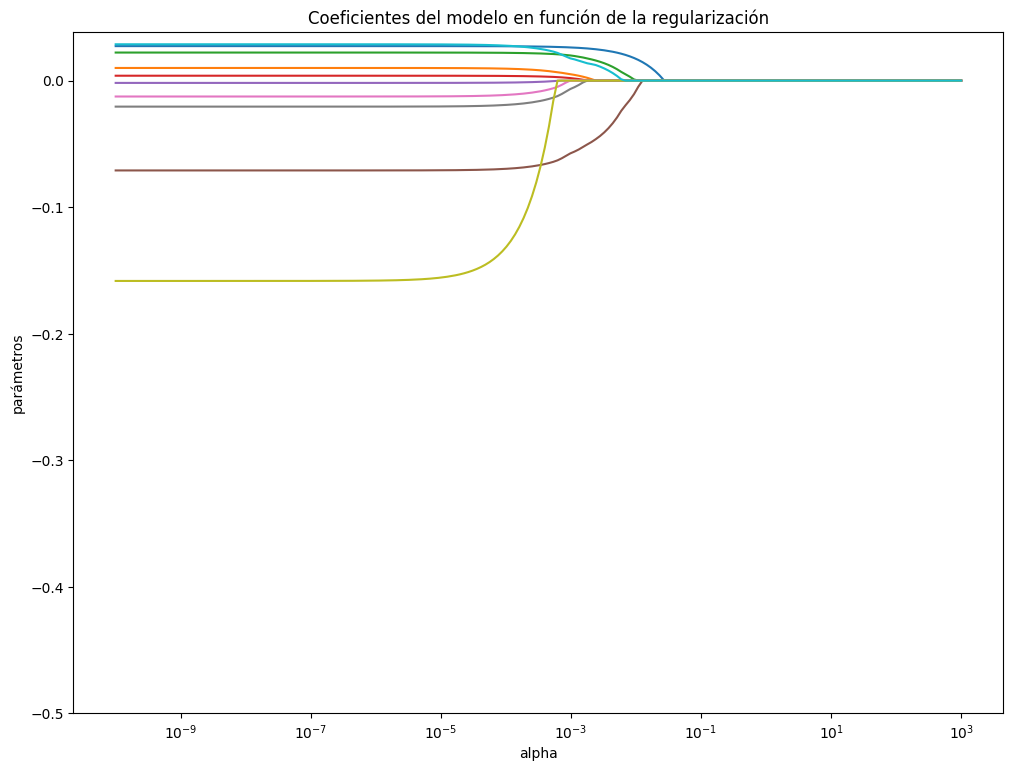

In [319]:
# Evolución de los parámetros en función de alpha

alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train_scaled)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(12, 8.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.set_title('Coeficientes del modelo en función de la regularización');

Text(0.5, 1.0, 'Features incluidas en función de la regularización')

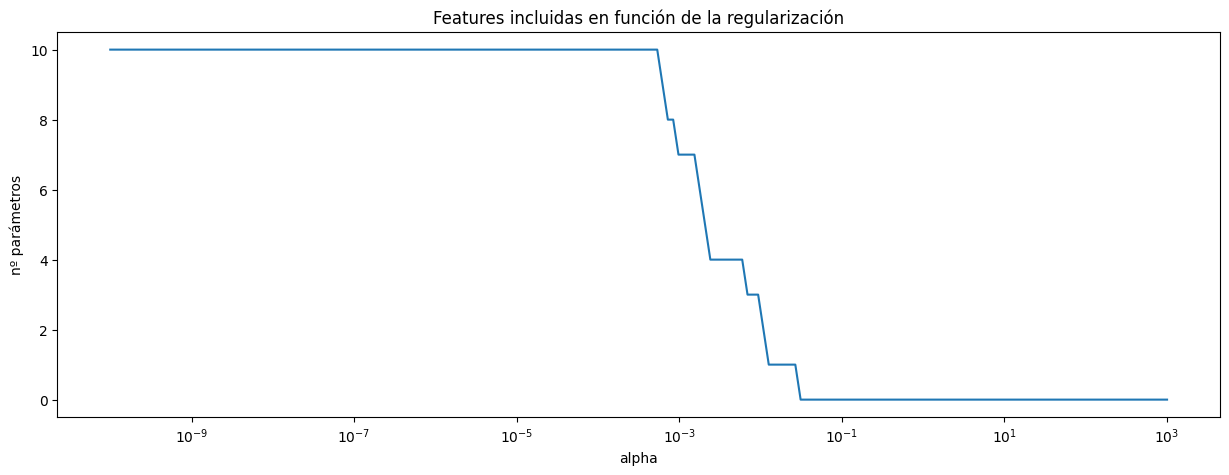

In [320]:
# Número de features incluidas (parámetros !=0) en función de alpha

alphas = modelo.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train_scaled)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº parámetros')
ax.set_title('Features incluidas en función de la regularización')

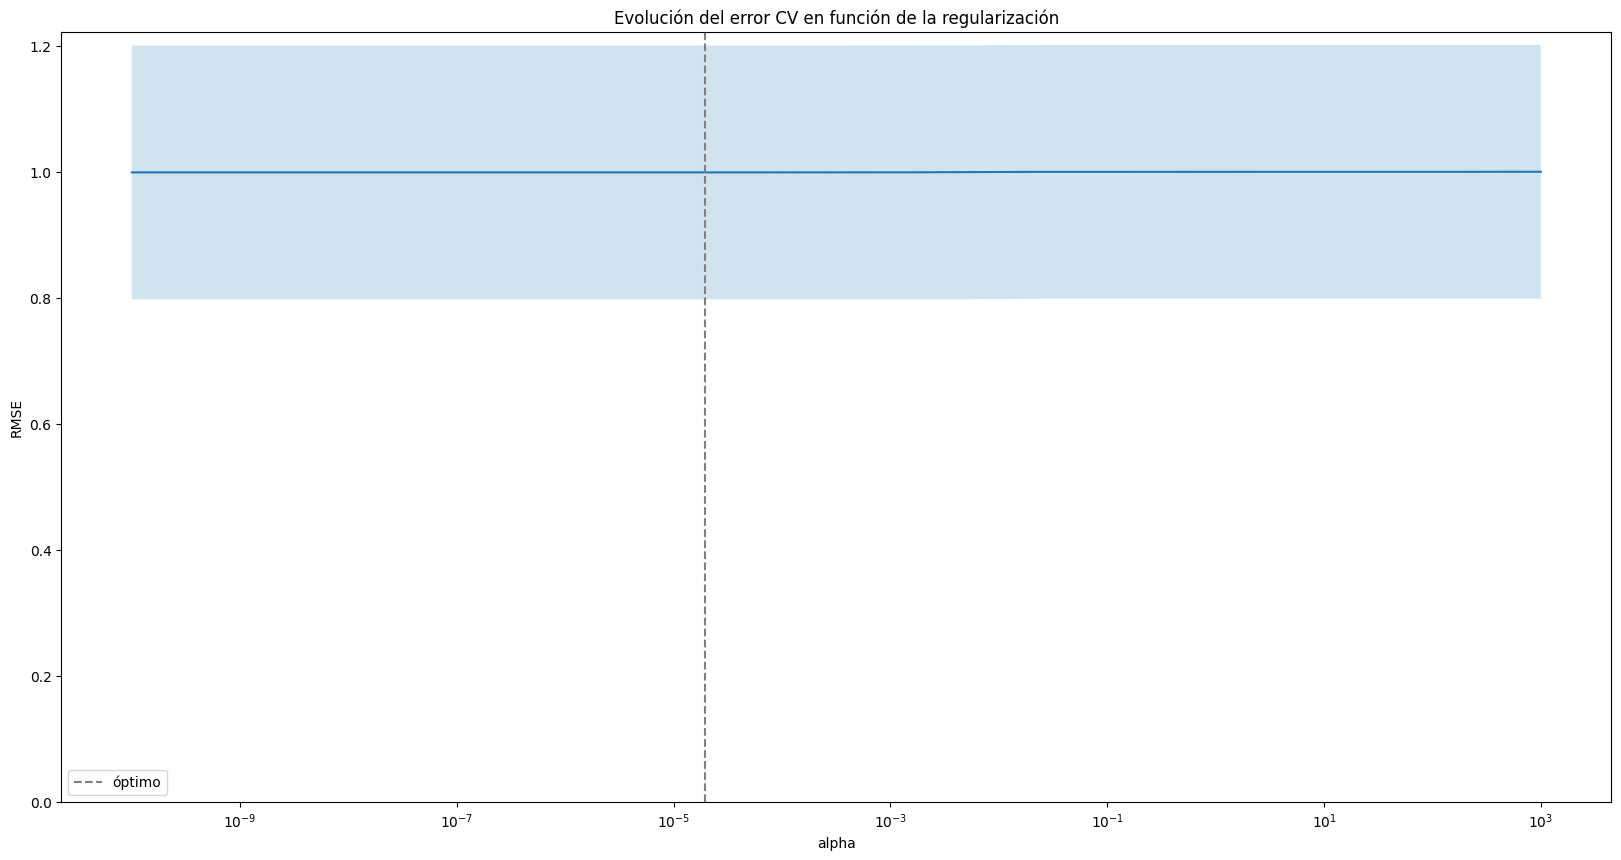

In [321]:
# Evolución del error de validación cruzada en función de alpha

mse_cv = modelo.mse_path_.mean(axis=1)
mse_sd = modelo.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
optimo       = modelo.alphas_[np.argmin(rmse_cv)]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(modelo.alphas_, rmse_cv)
ax.fill_between(
    modelo.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend()

In [322]:
# Mejor valor alpha encontrado

print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 1.956398343517065e-05


In [323]:
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
0,dist_haversine,0.027279
1,es_no_laborable,0.005018
2,hora_sin,0.023636
3,hora_cos,0.004751
4,1era_mitad_mes,-0.007648
5,invierno,-0.083519
6,primavera,-0.025542
7,verano,-0.033674
8,delivery,-0.185327
9,standard,-0.004317


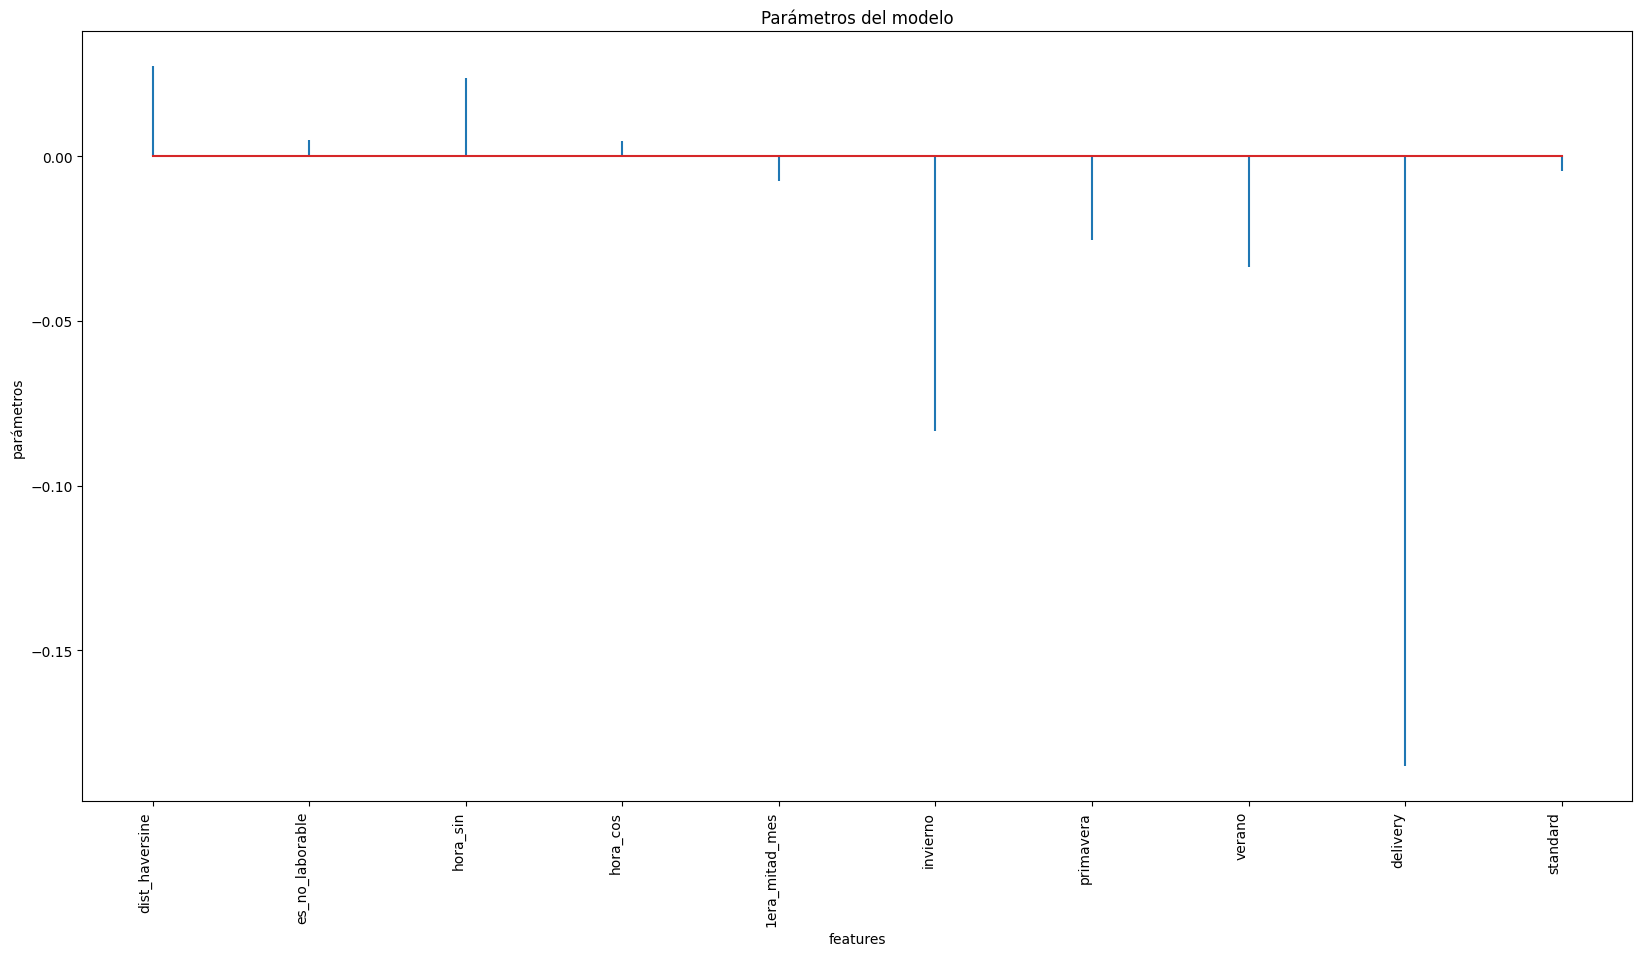

In [324]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('features')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [325]:
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([ 0.0325207 , -0.00371077, -0.01121446,  0.01648869,  0.02610649,
        0.01831913, -0.05511297, -0.03364014,  0.00529421,  0.00792166])

In [326]:
# Error de test del modelo 

rmse_lasso = np.sqrt(mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
             ))
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 15.365538459916769


In [327]:
R2 = r2_score(y_test, predicciones)
R2

-1.2206312650615168

In [328]:
modelo = ElasticNetCV(
            l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.logspace(-10, 3, 200),
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train_scaled.flatten())

c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.134e+04, tolerance: 1.427e+01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coo

In [329]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = modelo.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [modelo.l1_ratio, modelo.alphas_],
                                    names     = ['l1_ratio', 'modelo.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

,l1_ratio,modelo.alphas_,mse_cv,rmse_cv
308,0.10,0.000088,0.998085,0.999042
309,0.10,0.000076,0.998085,0.999042
307,0.10,0.000102,0.998085,0.999042
310,0.10,0.000065,0.998085,0.999042
306,0.10,0.000119,0.998085,0.999042
...,...,...,...,...
664,0.70,0.065932,1.000014,1.000007
665,0.70,0.056724,1.000014,1.000007
666,0.70,0.048803,1.000014,1.000007
1000,0.95,1000.000000,1.000014,1.000007


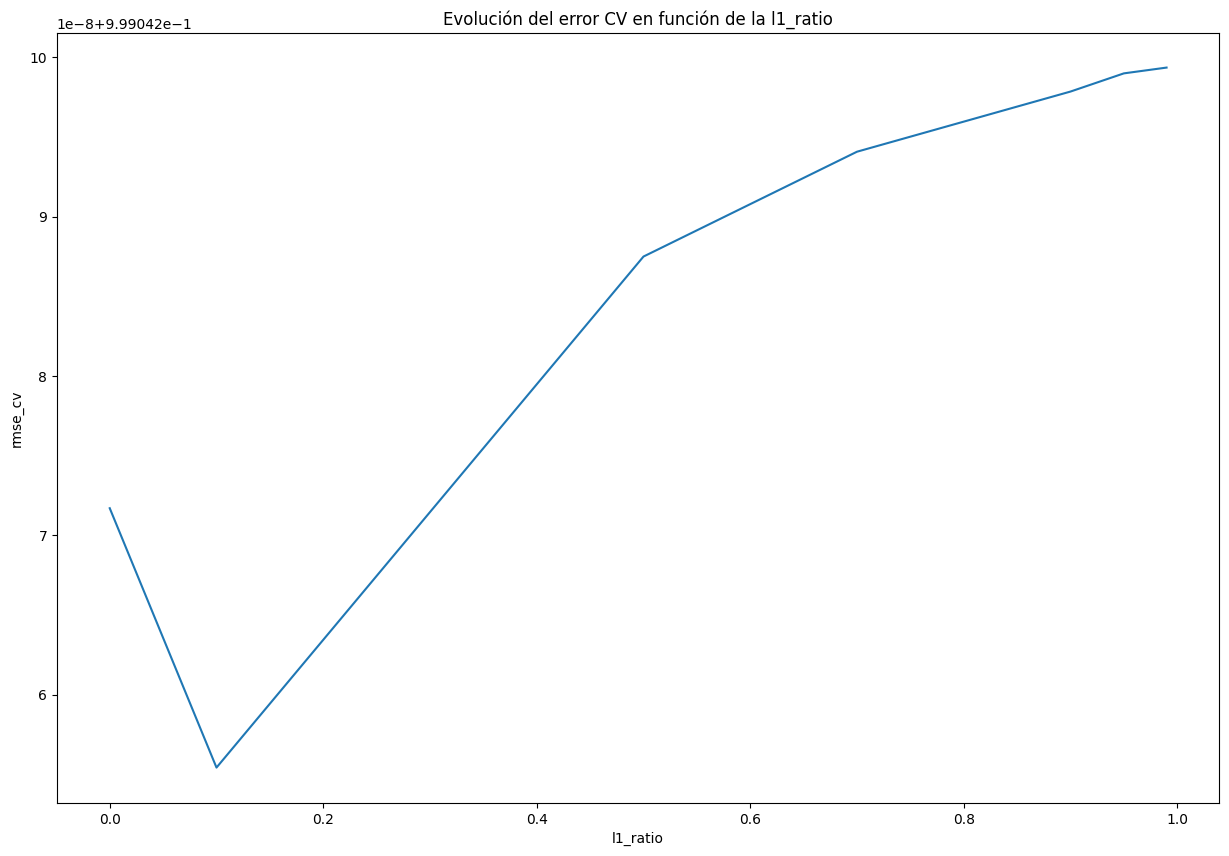

In [330]:
fig, ax = plt.subplots(figsize=(15, 10))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [331]:
# Mejor valor alpha y l1_ratio_ encontrado

print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo.l1_ratio_}")

Mejor valor de alpha encontrado: 8.804883581643464e-05
Mejor valor de l1_ratio encontrado: 0.1


In [332]:
# Parámetros del modelo
df_coeficientes = pd.DataFrame(
    {
        'predictor': X_train.columns,
        'coef': modelo.coef_.flatten()
    }
)

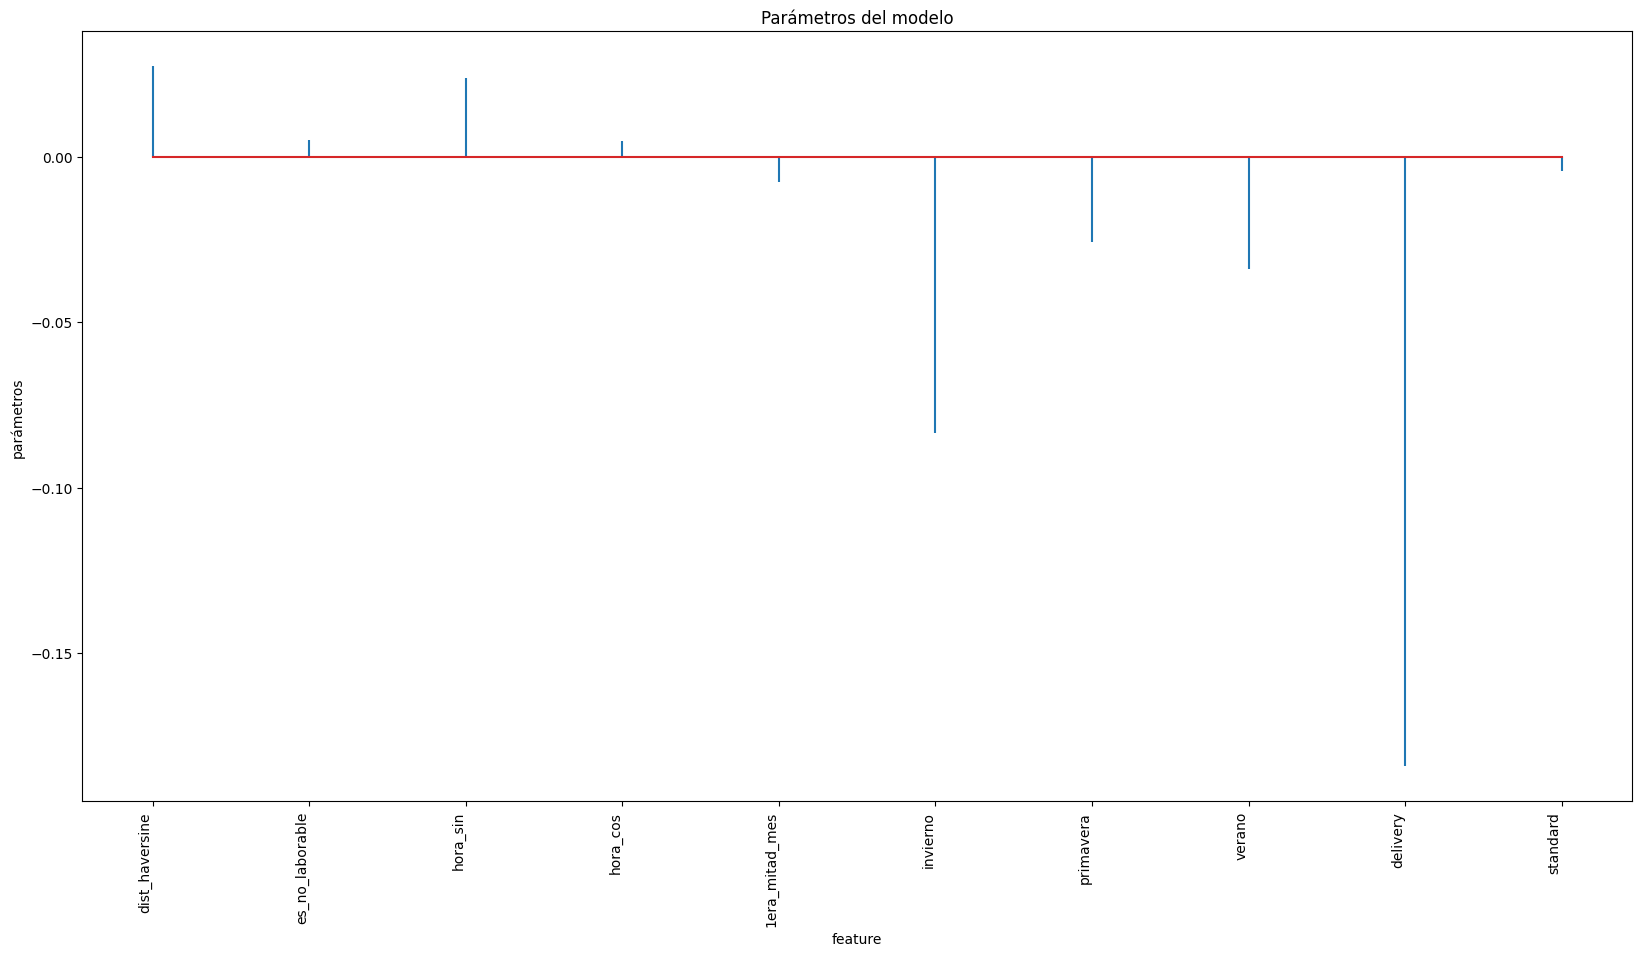

In [333]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [334]:
# Predicciones test

predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()

In [335]:
# Error de test del modelo 

rmse_elastic = np.sqrt(mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
               ))
print("")
print(f"El error (rmse) de test es: {rmse_elastic}")


El error (rmse) de test es: 15.365538659273717


In [336]:
R2 = r2_score(y_test, predicciones)
R2

-1.2206313226837446

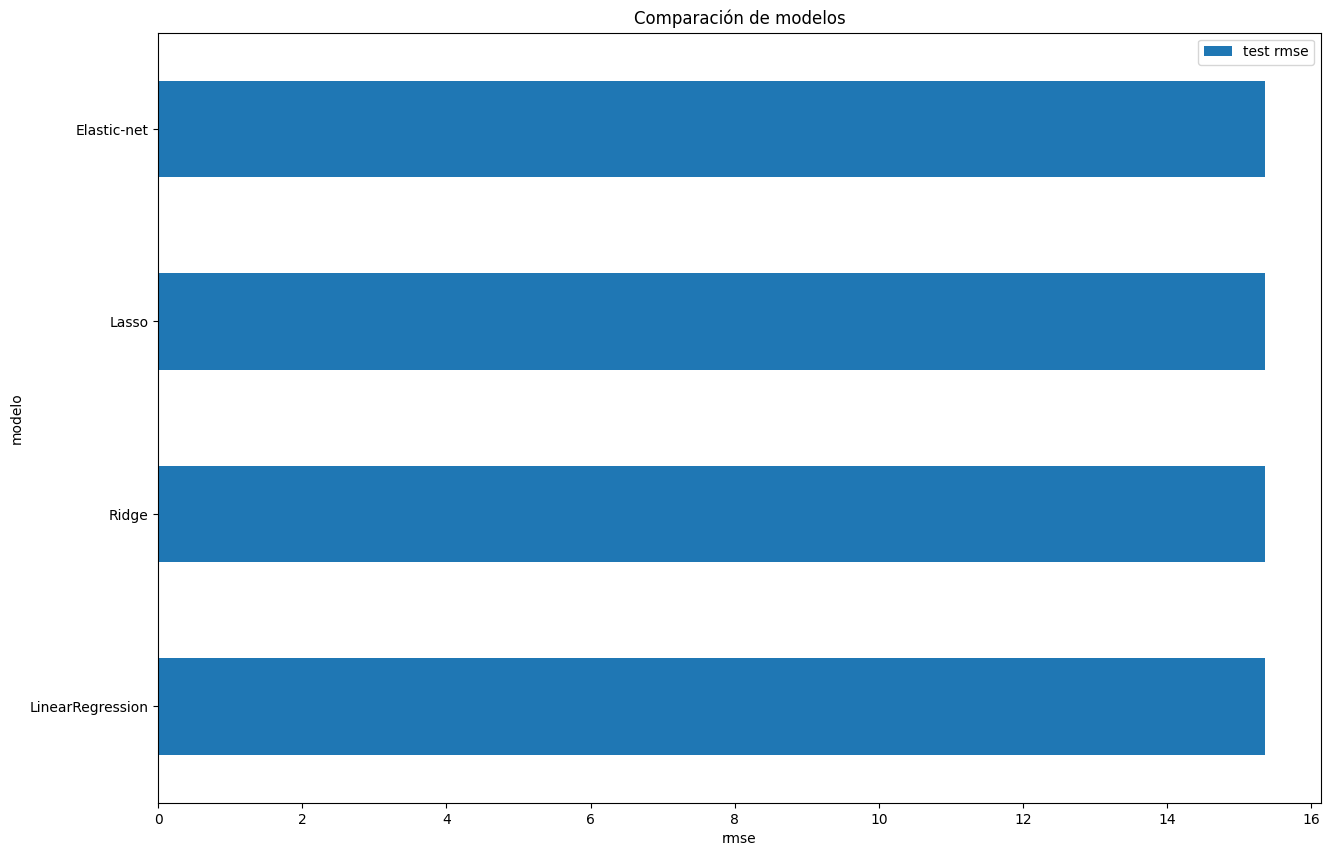

In [337]:
df_comparacion = pd.DataFrame({
                    'modelo': ['LinearRegression', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(15, 10))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');